
# A/B Testing Challenge
---

## Goal

A/B tests play a huge role in website optimization. Analyzing A/B tests data is a very important data scientist responsibility. Especially, data scientists have to make sure that results are reliable, trustworthy, and conclusions can be drawn.


Furthermore, companies often run tens, if not hundreds, of A/B tests at the same time. Manually analyzing all of them would require lot of time and people. Therefore, it is common practice to look at the typical A/B test analysis steps and try to automate as much as possible. This frees up time for the data scientists to work on more high level topics.
In this challenge, you will have to analyze results from an A/B test. Also, you will be asked to design an algorithm to automate some steps.

## Challenge Description
Company XYZ is a worldwide e-commerce site with localized versions of the site.
A data scientist at XYZ noticed that Spain-based users have a much higher conversion rate than any other Spanish-speaking country. She therefore went and talked to the international team in charge of Spain And LatAm to see if they had any ideas about why that was happening.

Spain and LatAm country manager suggested that one reason could be translation. All Spanish- speaking countries had the same translation of the site which was written by a Spaniard. They agreed to try a test where each country would have its one translation written by a local. That is, Argentinian users would see a translation written by an Argentinian, Mexican users by a Mexican and so on. Obviously, nothing would change for users from Spain.
After they run the test however, they are really surprised cause the test is negative. I.e., it appears that the non-localized translation was doing better!

### You are asked to:
Confirm that the test is actually negative. That is, it appears that the old version of the site with just one translation across Spain and LatAm performs better
Explain why that might be happening. Are the localized translations really worse?


If you identified what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and the results can be trusted.


## Data
We have 2 tables in the Translation_test folder. The Translation_test folder can be found in the folder : <br> interview_challenges/data_challenges/Translation_test

There are two tables in the folder.

#### Table 1 - test_table

Columns:

user_id : the id of the user. Unique by user. Can be joined to user id in the other table. For each user, we just check whether conversion happens the first time they land on the site since the test started. <br>

date : when they came to the site for the first time since the test started <br>

source : marketing channel: Ads, SEO, Direct . Direct means everything except for ads and SEO. Such as directly typing site URL on the browser, downloading the app w/o coming from SEO or Ads, referral friend, etc. <br>

device : device used by the user. It can be mobile or web<br>

browser_language : in browser or app settings, the language chosen by the user. It can be EN, ES, Other (Other means any language except for English and Spanish) <br>

ads_channel : if marketing channel is ads, this is the site where the ad was displayed. It can be: Google, Facebook, Bing, Yahoo ,Other. If the user didn't come via an ad, this field is NA <br>

browser : user browser. It can be: IE, Chrome, Android_App, FireFox, Iphone_App, Safari, Opera <br>

conversion : whether the user converted (1) or not (0). This is our label. A test is considered successful if it increases the proportion of users who convert. <br>

test : users are randomly split into test (1) and control (0). Test users see the new translation and control the old one. For Spain-based users, this is obviously always 0 since there is no change there.
      "test_table" - general information about the test results
              "user_table" - some information about the user


___ 

#### Table 2 - user_table

Columns:
user_id : the id of the user. It can be joined to user id in the other table 

sex : user sex: Male or Female <br>

age : user age (self-reported) <br>

country : user country based on ip address <br>





In [166]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import ttest_ind 

sns.set_style("whitegrid")
%matplotlib inline

In [138]:
user_table = pd.read_csv('Translation_Test/user_table.csv')
test_table = pd.read_csv('Translation_Test/test_table.csv')

In [85]:
def get_conversions(df, get_ratios=1):
    conversions = np.array(df.groupby(['test', 'conversion']).size().unstack())
    conversions = pd.DataFrame(conversions, columns=['not_converted', 'converted'], index=['control', 'experiment'])
    if get_ratios:
        return conversions.T / conversions.sum(axis=1)
    return conversions.T

In [15]:
print 'Tests Shape: {}, Users Shape: {}'.format(test_table.shape, user_table.shape) 
## not all users are assigned to a test
print test_table.user_id.nunique()
print user_table.user_id.nunique()
not_assigned_users = set(user_table.user_id.unique()) - set(test_table.user_id.unique()) 

Tests Shape: (453321, 9), Users Shape: (452867, 4)
453321
452867


In [62]:
test_table.head(3)

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0


In [63]:
user_table.head(3)

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia


In [64]:
test_table.browser_language.value_counts()

ES       377547
EN        63137
Other     12637
Name: browser_language, dtype: int64

In [65]:
user_table.country.value_counts()

Mexico         128484
Colombia        54060
Spain           51782
Argentina       46733
Peru            33666
Venezuela       32054
Chile           19737
Ecuador         15895
Guatemala       15125
Bolivia         11124
Honduras         8568
El Salvador      8175
Paraguay         7347
Nicaragua        6723
Costa Rica       5309
Uruguay          4134
Panama           3951
Name: country, dtype: int64

In [82]:
user_tests = user_table.merge(test_table, on='user_id')

In [98]:
country_conversions = user_tests.groupby('country')['conversion'].sum() / user_tests.groupby('country')['conversion'].size()

In [99]:
country_conversions.sort_values(ascending=False)

country
Spain          0.079719
Costa Rica     0.053494
Nicaragua      0.053399
Colombia       0.051332
El Salvador    0.050765
Mexico         0.050341
Peru           0.050258
Chile          0.049704
Venezuela      0.049666
Guatemala      0.049653
Honduras       0.049253
Ecuador        0.049072
Paraguay       0.048863
Bolivia        0.048634
Panama         0.048089
Argentina      0.013994
Uruguay        0.012821
dtype: float64

In [111]:
users_not_spain = user_tests.loc[user_tests.country != 'Spain']
experiment_not_spain = users_not_spain.loc[users_not_spain['test'] == 1, 'conversion']
control_not_spain = users_not_spain.loc[users_not_spain['test'] == 0, 'conversion']

In [117]:
print 'Not Spanish Control Conversion: ', control_not_spain.mean()
print 'Spanish Experimental Conversion:', experiment_not_spain.mean()

Not Spanish Control Conversion:  0.0482917905575
Spanish Experimental Conversion: 0.0434111616784


In [118]:
ttest_ind(control_not_spain, experiment_not_spain)

Ttest_indResult(statistic=7.382252163053967, pvalue=1.5593292778816856e-13)

In [144]:
date_control = pd.to_datetime(users_not_spain.loc[users_not_spain['test'] == 1, 'date']).value_counts()
date_exp = pd.to_datetime(users_not_spain.loc[users_not_spain['test'] == 0, 'date']).value_counts()

In [145]:
date_control = sorted(zip(date_control.index, date_control), key=lambda x: x[0])
date_exp = sorted(zip(date_exp.index, date_exp), key=lambda x: x[0])

In [173]:
dates = map(lambda x: x[0].date(), date_control)

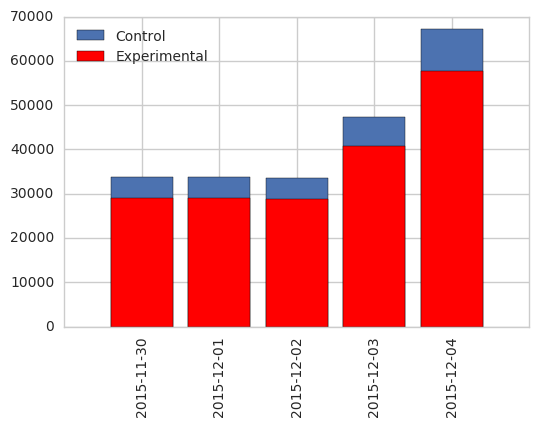

In [188]:
plt.bar(range(len(dates)), map(lambda x: x[1], date_control), align='center', label='Control')
plt.bar(range(len(dates)), map(lambda x: x[1], date_exp), align='center', color='r', label='Experimental')

plt.xticks(range(len(dates)), dates, rotation=90)
plt.legend(loc='upper left')
plt.show()

In [189]:
for cntry in user_tests.country.unique():
    try:
        cntry_df = user_tests[user_tests['country'] == cntry]
        print 
        print 'Country:{}'.format(cntry)
        print 
        print get_conversions(cntry_df)
        print ttest_ind(cntry_df.loc[cntry_df['test'] == 0, 'conversion'], 
                        cntry_df.loc[cntry_df['test'] == 1, 'conversion'])
        
    except:
        print 
        #print 'This is an error: {}'.format(cntry)


Country:Mexico

                control  experiment
not_converted  0.950505    0.948814
converted      0.049495    0.051186
Ttest_indResult(statistic=-1.3866622608887011, pvalue=0.1655471793333996)

Country:Nicaragua

                control  experiment
not_converted  0.947353    0.945823
converted      0.052647    0.054177
Ttest_indResult(statistic=-0.27887298868544658, pvalue=0.78035087831788208)

Country:Colombia

                control  experiment
not_converted  0.947911    0.949429
converted      0.052089    0.050571
Ttest_indResult(statistic=0.79996776451522145, pvalue=0.42373298936771575)

Country:Venezuela

                control  experiment
not_converted  0.949656    0.951022
converted      0.050344    0.048978
Ttest_indResult(statistic=0.56255845214574196, pvalue=0.57373952489624136)

Country:Spain



Country:Ecuador

                control  experiment
not_converted  0.950846    0.951012
converted      0.049154    0.048988
Ttest_indResult(statistic=0.048256568065656126, p